In [417]:
import numpy as np
import seaborn as sns
import cv2

from scipy.ndimage.filters import gaussian_filter

In [ ]:
def gauss_(s, k_pyr):
    n, m = s.shape
    s_new = np.zeros((n+2, m+2))
    s_new[1:-1, 1:-1] = s
    s_new[0, 1:-1] = s[0,:]
    s_new[-1, 1:-1] = s[-1, :]
    s_new[1:-1,0] = s[:,0]
    s_new[1:-1,-1] = s[:,-1]
    s_nxt = np.zeros((n, m))
#     print(s_new)
    
    for i in range(n):
        for j in range(m):
            s_nxt[i,j] = np.sum(s_new[i:i+3,j:j+3] * k_pyr)
#             print(i, j, s_nxt[i,j])
            
    return s_nxt


def gauss(s, k_pyr):
    n, m = s.shape
    s_nxt = np.zeros((n-2, m-2))
    
    for i in range(n-2):
        for j in range(m-2):
            s_nxt[i,j] = np.sum(s[i:i+3,j:j+3] * k_pyr)
            
    return s_nxt

In [292]:
def up_scale(l):
    n, m = l.shape

    ind_x = np.tile(np.arange(n), (m, 1)).T *2
    ind_y = np.tile(np.arange(m), (n, 1)) *2
    out = np.zeros((2*n, 2*m))

    out[ind_x, ind_y] = l
    out[ind_x+1, ind_y] = l
    out[ind_x, ind_y+1] = l
    out[ind_x+1, ind_y+1] = l

    return out

In [ ]:
def decimate(s):
    n, m  = s.shape
    ind_x = np.tile(np.arange(0, n, 2), (int((m+1)/2),1)).T
    ind_y = np.tile(np.arange(0, m, 2), (int((n+1)/2),1))
#     print(ind_x)
#     print(ind_y)
    
    return s[ind_x, ind_y]
    

In [ ]:
def num_laplace(G, k):
    return cv2.Laplacian(G, cv2.CV_64F) * 2**(-2*(k-1))

def my_num_laplace(G):
    kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
    out = gauss_(G, kernel)
    return out
    
#     return cv2.Laplacian(G, ddepth=cv2.CV_64F,ksize=3) #* 2**(-2*(k-1))

In [294]:
# n, m = 100, 100
# p = 3

# k_pyr = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) /16
# k = cv2.getGaussianKernel(3, 0)
# k = k*k.T


# print(k_pyr)
# print(k)

In [295]:
# s_nxt = gauss(s_ori, k_pyr)
# s_nxt_ = gauss_(s_ori, k_pyr)

# # s__ = cv2.filter2D(s, -1, k)
# s__ = cv2.GaussianBlur(s_ori , (3, 3), 0)

# print(s_nxt)
# print()
# print(s_nxt_)
# print()
# print(s__)



# # s = s_nxt
                 
# print(decimate(s__))                 

<h2> Main Loop

In [296]:
# k_lap = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

# # Gb = gauss(s, k_lap)
# Gb = cv2.Laplacian(s, cv2.CV_64F)

# print(s0)
# print(s1)

In [297]:
# x = .5
# y = cv2.Laplacian(x, cv2.CV_64F)

# print(y.shape)
# print(x.shape, y.shape)

<h2> Main

In [388]:
S = cv2.imread('C:/Users/User/Downloads/uni/CO421/image2.jpg', cv2.IMREAD_GRAYSCALE)
cv2.imshow('im1', S)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [545]:
# 0 to inf correction
S_mod = S.astype(np.float64)
S_mod += 1
S_mod = np.where(S>255, 255, S_mod)

print(np.min(S_mod), np.max(S_mod))

cv2.imshow('im2', S_mod/255)
cv2.waitKey(0)
cv2.destroyAllWindows()

3.0 255.99999999999991


In [546]:
s_ori = np.log(S_mod)

# S_ = np.exp(s_ori)
# cv2.imshow('im3', S_/255)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


p = 10

s_pyr = {}

s_pyr[1] = s_ori

for i in range(1, p):
    s = s_pyr[i]
    s_nxt = cv2.GaussianBlur(s , (3, 3), 0)
    s_pyr[i+1] = decimate(s_nxt)

for i in s_pyr:
    print(i, s_pyr[i].shape)
    

1 (600, 1200)
2 (300, 600)
3 (150, 300)
4 (75, 150)
5 (38, 75)
6 (19, 38)
7 (10, 19)
8 (5, 10)
9 (3, 5)
10 (2, 3)


In [547]:
for i in range(1, p+1):
    S_pyr = np.exp(s_pyr[i])
    for i in range(i-1):
        S_pyr = up_scale(S_pyr)
    cv2.imshow('im3', S_pyr/255)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [548]:
k = p

a = .1
b = 1000

l = {}

l[0] = s_pyr[p]
# l[0] = np.array(np.max(s_pyr[p])).reshape((1, 1))

Tk = 10


while k > 0:

    print("K", k, s_pyr[k].shape, l[0].shape, np.max(s_pyr[k]), np.max(l[0]))

    # print(s_pyr[k])
    # UPSAMPLE error
    if (s_pyr[k].shape[0] < l[0].shape[0]):
        l[0] = l[0][:-1, :]
    if (s_pyr[k].shape[1] < l[0].shape[1]):
        l[0] = l[0][:, :-1]


    Gb = num_laplace(s_pyr[k], k)

#     print("K", k, Gb.shape, s_pyr[k].shape, l[0].shape)
    # print(l)

    for j in range(1, Tk+1):
        
        Ga = num_laplace(l[j-1], k)
        # print(Ga.shape, Gb.shape, s_pyr[k].shape)
        
        G = Ga + a*(l[j-1]-s_pyr[k]) - b*(Ga-Gb)
        # print(G.shape)
        # print(np.max(G),np.max(Ga), np.max(Gb))

        u_a = np.sum(G*G)

        u_b = -1* np.sum(G * num_laplace(G, k))

        u_NSD = u_a/(a*u_a + (1+b)*u_b)
#         print("u_NDS", u_NSD)

        l[j] = l[j-1] -u_NSD*G
    #     print(l[j].shape)

        l[j] = np.maximum(s_pyr[k], l[j])

#         print ("J", j, Ga.shape, u_a.shape, u_b.shape, l[j].shape)
    
    out = l[Tk]
    l = {}
    l[0] = up_scale(out)
    print()
    
    
    k-= 1
    
print (out.shape)

K 10 (2, 3) (2, 3) 4.191401326066419 4.191401326066419

K 9 (3, 5) (4, 6) 4.295779620766383 4.1914547967736775

K 8 (5, 10) (6, 10) 4.452170180092242 4.2959331780400545

K 7 (10, 19) (10, 20) 4.878235675575677 4.452598776005438

K 6 (19, 38) (20, 38) 5.2912480572332 4.890663311303346

K 5 (38, 75) (38, 76) 5.534969970452513 5.328773532879069

K 4 (75, 150) (76, 150) 5.541512941575129 5.588323001030166

K 3 (150, 300) (150, 300) 5.542269835939125 5.667881925419334

K 2 (300, 600) (300, 600) 5.544198969649278 5.749979968906675

K 1 (600, 1200) (600, 1200) 5.545177444479562 5.801934655703318

(600, 1200)


0.9204836461399304


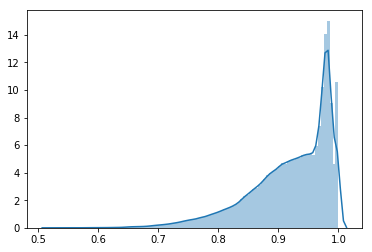

In [549]:
ill = out

ref = s_ori - ill

R = np.exp(ref)

sns.distplot(R.flatten(),  bins=100)
print(np.mean(R))

In [550]:
cv2.imshow('ref', R)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [551]:
# sns.distplot(ill.flatten(),  bins=100, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

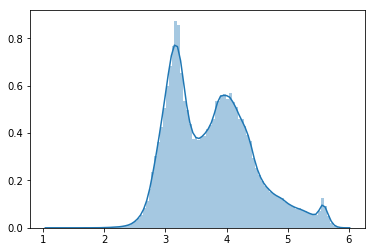

In [552]:
ill_mod = np.clip(ill, a_min = 0, a_max = 100)
sns.distplot(ill_mod.flatten(),  bins=100)

In [553]:
# sns.distplot(ill_mod.flatten(),  bins=100, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

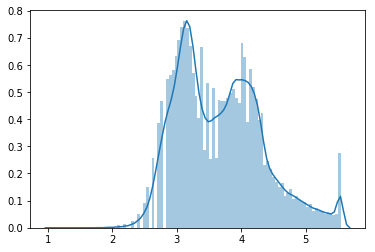

In [554]:
sns.distplot(s_ori.flatten(),  bins=100)

In [564]:
gamma = 4


L = np.exp(ill_mod)

S = np.exp(s_ori)

R = np.exp(ref)

W = np.ones(S.shape) * 255

L_ = W * np.power((L/W), 1/gamma)

# S_ = (L_/L) * S

S_ = L_ * R

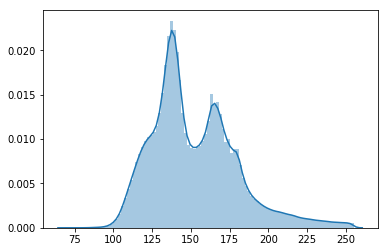

In [565]:
sns.distplot(S_.flatten(),  bins=100)

In [566]:
cv2.imshow('orig', S/255)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('GC', S_/255)
cv2.waitKey(0)
cv2.destroyAllWindows()